In [1]:
from typing import List

import cv2

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.python.framework.ops import Graph

In [2]:
def draw_rect(img: np.array, box: List[float], category: str, score: float):
    w, h, _ = img.shape
    y1, x1, y2, x2 = box
    scaled_min_point = (int(x1 * h), int(y1 * w))
    scaled_max_point = (int(x2 * h), int(y2 * w))
    cv2.rectangle(img, scaled_min_point, scaled_max_point, (255, 0, 0), 10)
    cv2.putText(
        img, "{} for {}%".format(category, round(score * 100, 2)), 
        (scaled_min_point[0], scaled_min_point[1] - 40), 
        cv2.FONT_HERSHEY_SIMPLEX, 3, (255, 0, 0), 20
    )


def print_img(
    img: np.array, 
    boxes: List[List[float]], 
    scores: List[float], 
    classes: List[float],
    threshold: float = 0.7
):
    copy_img = img.copy()
    for box, score, clss in zip(boxes, scores, classes):
        if score > threshold:
            draw_rect(copy_img, box, clss, score)

    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 20))
    plt.Figure()
    axes.imshow(copy_img)
    plt.show()
    
def load_graph(checkpoint_path: str) -> tf.Graph:
    detection_graph = tf.Graph()

    with detection_graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(checkpoint_path, 'rb') as f:
            od_graph_def.ParseFromString(f.read())
            tf.import_graph_def(od_graph_def, name='')

    return detection_graph


def detect_animals(detection_graph: Graph, image: np.array):
    with detection_graph.as_default():
        with tf.Session(graph=detection_graph) as sess:
            
            # expand image tensor from `width x height x 3` shape to `1 x width x height x 3`
            # this is required by model to input data in minibatch of size 1
            image_expanded = np.expand_dims(image, axis=0)

            # getting input tensor refrence
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

            # getting output tensors refrences
            boxes_tensor = detection_graph.get_tensor_by_name('detection_boxes:0')
            scores_tensor = detection_graph.get_tensor_by_name('detection_scores:0')
            classes_tensor = detection_graph.get_tensor_by_name('detection_classes:0')

            # run model on tensor image
            boxes, scores, classes = sess.run(
                [boxes_tensor, scores_tensor, classes_tensor],
                feed_dict={ image_tensor: image_expanded }
            )

            return boxes[0], scores[0], classes[0]

In [3]:
img = cv2.cvtColor(cv2.imread("dzik.jpeg"), cv2.COLOR_BGR2RGB)
detection_graph = load_graph("megadetector_v3.pb")

boxes, scores, classes = detect_animals(detection_graph, img)

In [4]:
print("BOXES:\n{}\n".format(boxes[:10]))
print("SCORES:\n{}\n".format(scores[:10]))
print("CLASSES:\n{}\n".format(scores[:10]))

BOXES:
[[0.5205546  0.20958096 0.7625182  0.4906657 ]
 [0.4808348  0.9699815  0.5094461  0.98805845]
 [0.47956362 0.96389556 0.51494265 0.98755383]
 [0.4758374  0.57384133 0.49803528 0.58841354]
 [0.4732416  0.95570546 0.5205893  0.9876511 ]
 [0.47621223 0.9678597  0.5257678  0.9894578 ]
 [0.52007216 0.44029376 0.5424188  0.45955515]
 [0.48098013 0.96051556 0.50852114 0.98297226]
 [0.4760906  0.9733918  0.50372326 0.98836994]
 [0.47661552 0.95794225 0.5411785  0.9852213 ]]

SCORES:
[0.9998673  0.02724109 0.01081221 0.00945431 0.00568144 0.00520552
 0.00350556 0.00313673 0.00203872 0.00176852]

CLASSES:
[0.9998673  0.02724109 0.01081221 0.00945431 0.00568144 0.00520552
 0.00350556 0.00313673 0.00203872 0.00176852]



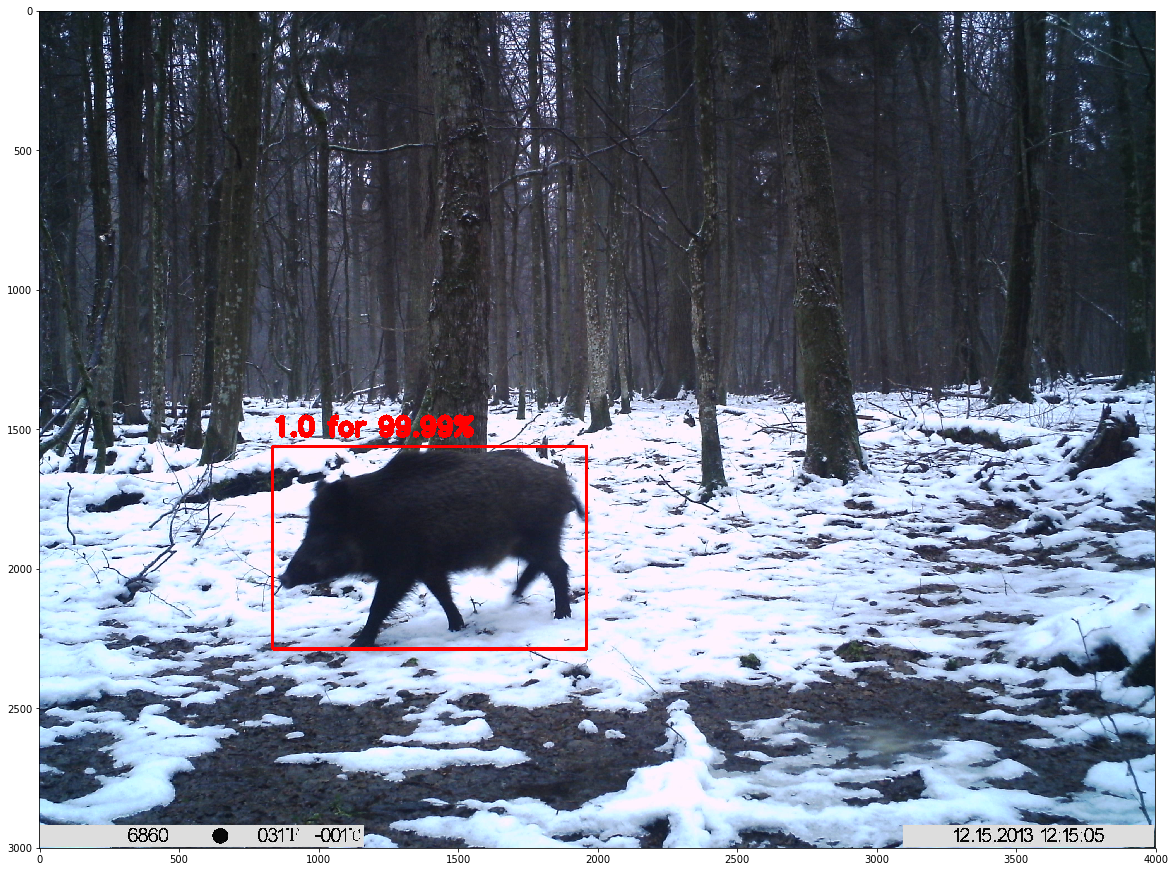

In [5]:
print_img(img, boxes, scores, classes, threshold=0.7)